useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [61]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
import cv2
import datetime
import gc
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

# # Keras + Tensorflow ML libraries
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D

# ===============================
# developed python libraries
# ===============================

In [62]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [63]:
def read_img(img_fpn):
    ans = cv2.imread(img_fpn, cv2.IMREAD_UNCHANGED)
    return ans

In [64]:
def std_img(img, minv, maxv):
    rangev = maxv - minv
    ans = img.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

In [65]:
def pad_img(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
    ans = np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode="constant", constant_values=0))
    return ans

In [66]:
def get_images(rootf, src_df, src_col, tgt_col):
    ans = src_df
    src_files = list(ans[src_col])
    tgt_files = list()

    # ansdict = {}
    for tfile in src_files:
        tfpn = os.path.join(rootf, tfile)
        # print(tfpn)
        # print(os.path.exists(tfpn))
        timg = read_img(tfpn)
        tgt_files.append(timg)

    ans[tgt_col] = tgt_files
    return ans

In [67]:
def padding_images(src_df, src_col, tgt_col, max_shape):
    ans = src_df
    src_images = list(ans[src_col])
    tgt_images = list()
    max_x, max_y = max_shape[0], max_shape[1]
    padding = None

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.array(timg, dtype="object")
        # std_timg = std_img(timg, 0, 255)
        pimg = pad_img(timg, max_y, max_x)
        tgt_images.append(pimg)

    ans[tgt_col] = tgt_images
    return ans

In [68]:
def standarize_images(src_df, src_col, tgt_col):
    ans = src_df
    src_images = list(ans[src_col])
    tgt_images = list()

    # ansdict = {}
    for timg in src_images:
        # print(timg)
        timg = np.array(timg, dtype="object")
        std_timg = std_img(timg, 0, 255)
        tgt_images.append(std_timg)

    ans[tgt_col] = tgt_images
    return ans

In [69]:
# function to get the max shape in the image dataset
def get_mshape(shape_data, imgt):

    max_x, max_y, max_ch = 0, 0, 0
    shape_data = list(shape_data)
    ans = None

    if imgt == "rgb":

        for tshape in shape_data:
            tshape = eval(tshape)
            tx, ty, tch = tshape[0], tshape[1], tshape[2]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            if tch > max_ch:
                max_ch = tch
            
        ans = (max_x, max_y, max_ch)
    
    elif imgt == "bw":

        for tshape in shape_data:
            tshape = eval(tshape)
            tx, ty = tshape[0], tshape[1]

            if tx > max_x:
                max_x = tx
            if ty > max_y:
                max_y = ty
            
        ans = (max_x, max_y)
        
    return ans

In [70]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with predictions txt data
imagef = "Img"

# report subfolder
reportf = "Reports"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Std"

# dataframe file extension
fext = "csv"

imgf = "jpg"

rgb_sufix = "rgb"
bw_sufix = "bw"

# standard sufix
stdprefix = "std-"

# ml model useful data
mltprefix = "ml-"

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")

small_sufix = "Img-Data-Small"
large_sufix = "Img-Data-Large"
painting_sufix = "Img-Data-Paintings"

gallery_prefix = "VVG-Gallery"

# dataframe file name
small_fn = stdprefix + gallery_prefix + "-" + small_sufix + "." + fext
large_fn = stdprefix + gallery_prefix + "-" + large_sufix + "." + fext
painting_fn = stdprefix + gallery_prefix + "-" + painting_sufix + "." + fext

# ramdom seed
randseed = 42

# sample distribution train vs test sample size
trainf = 0.80
testf = 0.20

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^std_)"

imgt = rgb_sufix

# default values
# work_fn, work_sufix, work_imgt = small_fn, small_sufix, rgb_sufix
work_fn, work_sufix, work_imgt = painting_fn, painting_sufix, imgt
# work_fn, work_sufix, work_imgt = large_fn, large_sufix, rgb_sufix

In [71]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer


In [72]:
# variable reading
# dataframe filepath
fn_path = os.path.join(root_folder, dataf, stdf, work_fn)
print(fn_path)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Std\std-VVG-Gallery-Img-Data-Paintings.csv


In [73]:
# rading training data
# loading file
source_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

In [74]:
# checking everything is allrigth
# source_df.head(5)
# chekcing the dataframe
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     211 non-null    object
 1   F-number               211 non-null    object
 2   JH-number              211 non-null    object
 3   Dimensions             211 non-null    object
 4   creator-place          211 non-null    object
 5   creator-date           211 non-null    object
 6   details                211 non-null    object
 7   rgb_img                211 non-null    object
 8   bw_img                 211 non-null    object
 9   rgb_shape              211 non-null    object
 10  bw_shape               211 non-null    object
 11  std_cat_creator-date   211 non-null    object
 12  std_cat_creator-place  211 non-null    object
 13  std_cat_Dimensions     211 non-null    object
 14  std_cat_details        211 non-null    object
dtypes: object(15)
memory us

In [75]:
# reading images from folder and loading images into df
# working variables
src_col = work_imgt + "_img"
tgt_col = work_imgt + "_img" + "_data"
work_shape = work_imgt + "_shape"

print(src_col, tgt_col)
source_df = get_images(root_folder, source_df, src_col, tgt_col)

rgb_img rgb_img_data


In [76]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     211 non-null    object
 1   F-number               211 non-null    object
 2   JH-number              211 non-null    object
 3   Dimensions             211 non-null    object
 4   creator-place          211 non-null    object
 5   creator-date           211 non-null    object
 6   details                211 non-null    object
 7   rgb_img                211 non-null    object
 8   bw_img                 211 non-null    object
 9   rgb_shape              211 non-null    object
 10  bw_shape               211 non-null    object
 11  std_cat_creator-date   211 non-null    object
 12  std_cat_creator-place  211 non-null    object
 13  std_cat_Dimensions     211 non-null    object
 14  std_cat_details        211 non-null    object
 15  rgb_img_data           

In [77]:
# searching the biggest shape in the image files
print(work_shape)
shape_data = source_df[work_shape]
max_shape = get_mshape(shape_data, work_imgt)
print(max_shape)

rgb_shape
(800, 800, 3)


In [78]:
# padding training data according to max shape of the images in gallery
pad_prefix = "pad_"
conv_prefix = "cnn_"
src_col = work_imgt + "_img" + "_data"
tgt_col = pad_prefix + conv_prefix + src_col

print(src_col, tgt_col)
source_df = padding_images(source_df, src_col, tgt_col, max_shape)

rgb_img_data pad_cnn_rgb_img_data


In [79]:
source_df.info()
# test = source_df["pad_cnn_rgb_img_data"].value_counts()
# print(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     211 non-null    object
 1   F-number               211 non-null    object
 2   JH-number              211 non-null    object
 3   Dimensions             211 non-null    object
 4   creator-place          211 non-null    object
 5   creator-date           211 non-null    object
 6   details                211 non-null    object
 7   rgb_img                211 non-null    object
 8   bw_img                 211 non-null    object
 9   rgb_shape              211 non-null    object
 10  bw_shape               211 non-null    object
 11  std_cat_creator-date   211 non-null    object
 12  std_cat_creator-place  211 non-null    object
 13  std_cat_Dimensions     211 non-null    object
 14  std_cat_details        211 non-null    object
 15  rgb_img_data           

In [80]:
# reading images from folder and stadarizing images into df
# working variables
print("standarizing regular images...")
src_col = work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

source_df = standarize_images(source_df, src_col, tgt_col)

standarizing regular images...


In [81]:
print("standarizing padded images...")
src_col = pad_prefix + conv_prefix + work_imgt + "_img" + "_data"
tgt_col = "std_" + src_col

source_df = standarize_images(source_df, src_col, tgt_col)

standarizing padded images...


In [82]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        211 non-null    object
 1   F-number                  211 non-null    object
 2   JH-number                 211 non-null    object
 3   Dimensions                211 non-null    object
 4   creator-place             211 non-null    object
 5   creator-date              211 non-null    object
 6   details                   211 non-null    object
 7   rgb_img                   211 non-null    object
 8   bw_img                    211 non-null    object
 9   rgb_shape                 211 non-null    object
 10  bw_shape                  211 non-null    object
 11  std_cat_creator-date      211 non-null    object
 12  std_cat_creator-place     211 non-null    object
 13  std_cat_Dimensions        211 non-null    object
 14  std_cat_details           

In [83]:
# selecting data to train
gc.collect()
# want to keep the columns starting with STD_
df_columns = list(source_df.columns)
print("------ original input/interested columns ------")
print(df_columns)

# create the columns Im interesting in
keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\n\n------ Interesting columns ------")
print(keep_columns)

------ original input/interested columns ------
['ID', 'F-number', 'JH-number', 'Dimensions', 'creator-place', 'creator-date', 'details', 'rgb_img', 'bw_img', 'rgb_shape', 'bw_shape', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'rgb_img_data', 'pad_cnn_rgb_img_data', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


------ Interesting columns ------
['ID', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'std_rgb_img_data', 'std_pad_cnn_rgb_img_data']


In [84]:
# creating the training dataframe
train_df = pd.DataFrame(source_df, columns=keep_columns)

In [85]:
# checking the train dataframe
train_df.head(5)
train_df.info()
source_df = None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        211 non-null    object
 1   std_cat_creator-date      211 non-null    object
 2   std_cat_creator-place     211 non-null    object
 3   std_cat_Dimensions        211 non-null    object
 4   std_cat_details           211 non-null    object
 5   std_rgb_img_data          211 non-null    object
 6   std_pad_cnn_rgb_img_data  211 non-null    object
dtypes: object(7)
memory usage: 11.7+ KB


In [86]:
regular_img_col = "std_" + work_imgt + "_img" + "_data"
padded_img_col = "std_" + pad_prefix + conv_prefix + work_imgt + "_img" + "_data"

In [87]:
working_img_col = padded_img_col
# working_img_col = regular_img_col

In [88]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
# X = np.array([np.array(i, dtype="object") for i in train_df[working_img_col]], dtype="object")
X = train_df[working_img_col]
print(X.shape)

(211,)


In [89]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
# y = np.array([np.array(j, dtype="object") for j in train_df[working_img_col]], dtype="object")
y = train_df[working_img_col]
print(y.shape)

(211,)


In [90]:
print(type(X[0]))
print(type(X[0][0]))
print(X.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(211,)


In [91]:
print(type(y[0]))
print(type(y[0][0]))
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(211,)


In [92]:
print(X[0].shape)
print(y[0].shape)

(800, 800, 3)
(800, 800, 3)


In [93]:
X_cnn = list()

for tx in X:
    tx = tf.convert_to_tensor(tx, dtype="float32")
    X_cnn.append(tx)

X_cnn = np.asarray(X_cnn, dtype="object")
# X_cnn = np.array(X_cnn, dtype=object)
# y_cnn = y
X = None

In [94]:
gc.collect()

59

In [95]:
y_cnn = list()

for ty in y:
    ty = tf.convert_to_tensor(ty, dtype="float32")
    y_cnn.append(ty)

y_cnn = np.asarray(y_cnn, dtype=object)
y = None

In [96]:
gc.collect()

73

In [97]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, train_size = trainf, test_size = testf, random_state = randseed)

In [98]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)
# print("X: ", len(X_train), " y: ", len(y_train))

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)
# print("X: ", len(X_test), " y: ", len(y_test))

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0][0]), type(y_test[0][0][0]))

training shape (X, y)
X:  (168, 800, 800, 3)  y:  (168, 800, 800, 3)
testing shape (X, y)
X:  (43, 800, 800, 3)  y:  (43, 800, 800, 3)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [99]:
if working_img_col == regular_img_col:

    Xtf_train = X_train
    Xtf_test = X_test
    ytf_train = y_train
    ytf_test = y_test

# only useable in padded images
elif working_img_col == padded_img_col:
    print("using", working_img_col)
    X_train = tf.convert_to_tensor(X_train, dtype="float32")
    X_test = tf.convert_to_tensor(X_test, dtype="float32")
    y_train = tf.convert_to_tensor(y_train, dtype="float32")
    y_test = tf.convert_to_tensor(y_test, dtype="float32")

# y_tensor = tf.convert_to_tensor(y, dtype=tf.float23) 

using std_pad_cnn_rgb_img_data


In [100]:
gc.collect()

57

In [101]:
# number of filters or processing units in CNN
# the number is because of good practices from computer vision
# min 8 max 64, normaly 32 (related to the size of the images)
# 16 for now in this test
# imgage filters
filters = 8
print("CNN filter number:", filters)

in_shape = X_train[0].shape
# in_shape = (None, None, 3)
# in_shape = (None, None, 1)
# in_shape = (794, 794, 3)
print("Input training shape:", in_shape)

# batch size
bs = int(X_train.shape[0]*0.01)+1
bs = 1
print("CNN learning batch size:", bs)

ksize = (3,3)
psize = (2,2)
print("CNN kernel size:", ksize)
print("CNN pad size:", psize)

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
mdn = 8*8*3
mid_reshape = (8,8,3)
print("Dense middle processing units:", mdn)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
# out_shape = X_train[0].shape
# out_shape = (None, None, 3)
out_shape = in_shape
print("Output prediction shape:", out_shape)

# axtivation functions
inn = "relu"
act = "relu"
out = "softmax"

# loss percentage
ldrop = 0.2

# padding policy
pad = "same"

# random seed
randseed = 42

# parameters to compile model
# loss function
# ls = "mean_squared_error"
# ls = "categorical_crossentropy"
ls = "binary_crossentropy"

# doptimization function
opti = "adam"
# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 300
print("training epochs:", epo)

CNN filter number: 8
Input training shape: (800, 800, 3)
CNN learning batch size: 1
CNN kernel size: (3, 3)
CNN pad size: (2, 2)
Dense middle processing units: 192
Output prediction shape: (800, 800, 3)
training epochs: 300


In [103]:
# model layers
# https://stackoverflow.com/questions/45038786/2d-convolutional-neural-networks-with-variable-size-images
# to avoid overfit you need to use dropout in someplaces
# options:
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Drop -> Dense -> Drop -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Dense -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 2) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM2 -> Dense -> LSTM2 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> LSTM2 -> Drop -> Dense -> Drop -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> STM1 -> Drop -> TimeDistDense
# 5) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> LSTM1 -> TimeDistDense

cnn_layers = (

    # input layer (padding and prep)
    Input(shape = in_shape, name = "LayIn"),
    # Conv2D(filters, ksize, activation = act, padding = padp, input_shape = in_shape, name = "LayIn"),
    # ZeroPadding2D(padding = padsh),

    # intermediate convolutional encoder layer
    Conv2D(filters, ksize, activation = act, padding = pad, name = "EnConv1"),
    MaxPooling2D(psize, padding = pad, name = "EnPool1"),
    Dropout(ldrop, name = "EnDrop1"),

    # intermediate convolutional encoder layer
    Conv2D(int(filters/2), ksize, activation=act, padding = pad, name = "EnConv2"),
    MaxPooling2D(psize, padding = pad, name = "EnPool2"),
    Dropout(ldrop, name = "EnDrop2"),

    # intermediate convolutional encoder layer
    # Conv2D(int(filters/4), ksize, activation=act, padding = pad, name = "EnConv3"),
    # MaxPooling2D(psize, padding = pad, name = "EnPool3"),
    # Dropout(ldrop, name = "EnDrop3"),

    # #from 2D to 1D
    # Flatten(name = "LayFlat"),
    # # mid dense encoding layer
    # # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)
    # Dense(mdn, activation = act, name = "DenseMid"),
    # Dropout(ldrop, name = "MidDrop"),
    # # from 1D to 2D
    # Reshape(mid_reshape, name = "layReshape"),
    
    # intermediate convolutional decoder layer
    Conv2D(int(filters/4), ksize, activation = act, padding = pad, name = "DeConv1"),
    UpSampling2D(psize, name = "DeUpsam1"),
    Dropout(ldrop, name = "DeDrop1"),

    # intermediate convolutional decoder layer
    # Conv2D(int(filters/2), ksize, activation = act, padding = pad, name = "DeConv1"),
    # UpSampling2D(psize, name = "DeUpsam1"),
    # Dropout(ldrop, name = "DeDrop1"),

    # intermediate convolutional decoder layer
    Conv2D(filters, ksize, activation = act, padding = pad, name = "DeConv2"),
    UpSampling2D(psize, name = "DeUpsam2"),
    Dropout(ldrop, name = "DeDrop2"),
    # capa de salida
    # Reshape(inshape),
    Conv2D(3, ksize, activation = out, padding = pad, input_shape = out_shape, name = "LayOut"),
)

In [104]:
# defining model
cnn_model = Sequential(cnn_layers)
cnn_model.model_name = "CNN_Autoencoder"

In [105]:
# compile model
cnn_model.compile(loss = ls, optimizer = opti, metrics = met)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EnConv1 (Conv2D)             (None, 800, 800, 8)       224       
_________________________________________________________________
EnPool1 (MaxPooling2D)       (None, 400, 400, 8)       0         
_________________________________________________________________
EnDrop1 (Dropout)            (None, 400, 400, 8)       0         
_________________________________________________________________
EnConv2 (Conv2D)             (None, 400, 400, 4)       292       
_________________________________________________________________
EnPool2 (MaxPooling2D)       (None, 200, 200, 4)       0         
_________________________________________________________________
EnDrop2 (Dropout)            (None, 200, 200, 4)       0         
_________________________________________________________________
DeConv1 (Conv2D)             (None, 200, 200, 2)       7

In [106]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopCNN_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 30, verbose = 1, mode = "max", restore_best_weights = True)

In [107]:
# training model
history_cnn = cnn_model.fit(
    x = X_train, 
    y = y_train,
    epochs = epo, 
    verbose = ver, 
    workers = 6,
    batch_size = bs, 
    callbacks = [EarlyStopCNN_Acc],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (X_test, y_test),
)

Epoch 1/300
168/168 [==============================] - 90s 531ms/step - loss: 0.6326 - accuracy: 0.3364 - val_loss: 0.4643 - val_accuracy: 0.3218
Epoch 2/300
168/168 [==============================] - 82s 485ms/step - loss: 0.4608 - accuracy: 0.3184 - val_loss: 0.4586 - val_accuracy: 0.3376
Epoch 3/300
168/168 [==============================] - 71s 420ms/step - loss: 0.4539 - accuracy: 0.3383 - val_loss: 0.4515 - val_accuracy: 0.3213
Epoch 4/300
168/168 [==============================] - 75s 447ms/step - loss: 0.4516 - accuracy: 0.3796 - val_loss: 0.4479 - val_accuracy: 0.3219
Epoch 5/300
168/168 [==============================] - 76s 450ms/step - loss: 0.4500 - accuracy: 0.4081 - val_loss: 0.4442 - val_accuracy: 0.4279
Epoch 6/300
168/168 [==============================] - 75s 444ms/step - loss: 0.4472 - accuracy: 0.4891 - val_loss: 0.4429 - val_accuracy: 0.6377
Epoch 7/300
168/168 [==============================] - 71s 423ms/step - loss: 0.4448 - accuracy: 0.5415 - val_loss: 0.4439 -

In [108]:
# evaluationg model
cnn_eval = cnn_model.evaluate(x = X_test, y = y_test)

2/2 [==============================] - 4s 907ms/step - loss: 0.4392 - accuracy: 0.7744


In [109]:
# general evaluation 
print("avg loss: ", cnn_eval[0])
print("avg acc: ", cnn_eval[1])

avg loss:  0.43920108675956726
avg acc:  0.7743715047836304


In [110]:
# testing model
cnn_results = cnn_model.predict(X_test, batch_size = bs, verbose = 1)#, batch_size = bs)

43/43 [==============================] - 4s 81ms/step


In [111]:
# saving model
wdir = os.getcwd()
models_folder = "Models"
model_fname = "vvg_cnn_autoencoder"
model_fpn = os.path.join(root_folder, dataf, models_folder, model_fname)
print("The trained  model is:", model_fpn)
cnn_model.save(model_fpn)

The trained  model is: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_cnn_autoencoder
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_cnn_autoencoder\assets


In [112]:
# cheking test shape
print(cnn_results.shape)

(43, 800, 800, 3)


<ipython-input-113-8fe4924f5382>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


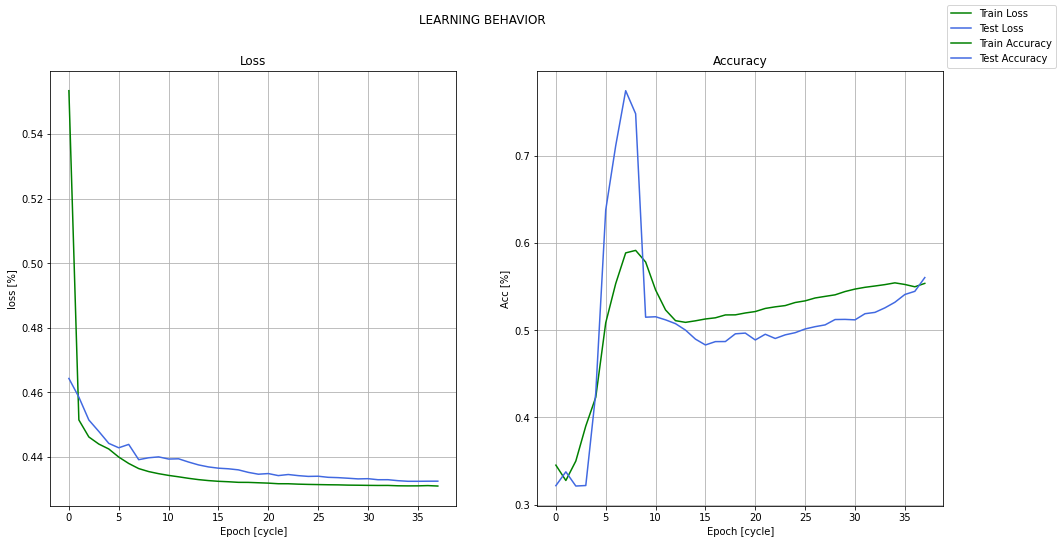

In [113]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(history_cnn.history["loss"], 'green', label = "Train Loss")
ax1.plot(history_cnn.history["val_loss"], 'royalblue', label = "Test Loss")
ax2.plot(history_cnn.history["accuracy"], 'green', label = "Train Accuracy")
ax2.plot(history_cnn.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [114]:
# saving image in png file
imgext = "jpg"
work_learn_img = model_fname + "-" + str_date + "-" + work_sufix + "-learn-curve." + imgext
img_fpn = os.path.join(root_folder, dataf, reportf, work_learn_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Reports\vvg_cnn_autoencoder-17-May-2021-Img-Data-Paintings-learn-curve.jpg


In [115]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)